In [45]:
import pandas as pd
import dask.dataframe as dd
import io
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [4]:
file_name = "2020_Business_Academic_QCQ.txt"
city = 'HILO'
state = 'HI'

def create_df(file_name, city, state):
    lines_left = True
    with open(file_name, encoding='ISO-8859-1') as f:
        header = f.readline()
        whole_df = None
        while True:
            lines = [header]
            for i in range(5000):
                line = f.readline()
                if not line:
                    lines_left = False
                    break
                lines.append(line)
            df = pd.read_csv(io.StringIO("\n".join(lines)))
            df_filtered = df[(df['City'] == city) & (df['State'] == state)]
            if len(df_filtered) > 0:
                whole_df = df_filtered if whole_df is None else pd.concat([whole_df, df_filtered])
            if not lines_left:
                return whole_df
                


In [5]:
df = create_df(file_name, city, state)

In [3]:
hilo_foot_traffic = pd.read_parquet('hilo_full_patterns.parquet')

In [12]:
hilo_foot_traffic['year'] = hilo_foot_traffic['date_range_start'].str[0:4].astype("Int64")
hilo_foot_traffic_2020 = hilo_foot_traffic[hilo_foot_traffic['year'] == 2020]

In [47]:
hilo_foot_traffic_2020['location_name'] = [x.upper() for x in list(hilo_foot_traffic_2020['location_name'])]
hilo_foot_traffic_2020['street_address'] = [x.upper() for x in list(hilo_foot_traffic_2020['street_address'])]

<ipython-input-47-b31273acf2d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hilo_foot_traffic_2020['location_name'] = [x.upper() for x in list(hilo_foot_traffic_2020['location_name'])]
<ipython-input-47-b31273acf2d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hilo_foot_traffic_2020['street_address'] = [x.upper() for x in list(hilo_foot_traffic_2020['street_address'])]


In [48]:
hilo_foot_traffic_2020_com = hilo_foot_traffic_2020.groupby(['location_name', 'latitude', 'longitude', 'street_address']).agg({'raw_visit_counts': 'sum'}).reset_index()

In [49]:
hilo_foot_traffic_2020_com

,location_name,latitude,longitude,street_address,raw_visit_counts
0,'OHANA ENDODONTICS,19.707470,-155.074925,31 E LANIKAULA ST STE C,1.0
1,1 PLUS 1 CAFE,19.701519,-155.063193,315 E MAKAALA ST STE 110,688.0
2,2 THE POINT ACUPUNCTURE,19.709667,-155.066911,687 LAUKAPU ST,388.0
3,7-ELEVEN,19.702743,-155.074853,74 W KAWILI ST,3885.0
4,7-ELEVEN,19.709726,-155.075784,1321 KILAUEA AVE,2744.0
...,...,...,...,...,...
980,Z SPORTS,19.714879,-155.066123,504 KALANIKOA ST STE 7,1180.0
981,ZENDO KERN PLANNING CONSULTANT,19.701422,-155.066021,194 WIWOOLE ST,25.0
982,ZIEBART,19.702829,-155.067430,ZIEBART OF HILO HI,633.0
983,ZIPPY KLEAN MOBILE AUTO DETAILING,19.720444,-155.064590,200 KANOELEHUA AVE STE 207,123.0


In [55]:
business_sales = df[['Company', 'Address Line 1', 'Latitude', 'Longitude', 'Sales Volume (9) - Location']]

In [58]:
hilo_foot_traffic_2020_com.columns

Index(['location_name', 'latitude', 'longitude', 'street_address',
       'raw_visit_counts'],
      dtype='object')

In [63]:
from fuzzywuzzy import fuzz

# Define a function to fuzzy match rows based on multiple columns
def fuzzy_merge_rows(df1, df2, keys1, keys2, threshold=90):
    """
    :param df1: the left table to join
    :param df2: the right table to join
    :param keys1: key columns of the left table
    :param keys2: key columns of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :return: dataframe with boths keys and matches
    """
    matches = []
    for idx1, row1 in df1.iterrows():
        matches_row = []
        for idx2, row2 in df2.iterrows():
            # Convert values to strings
            values1 = [str(row1[key1]) for key1 in keys1]
            values2 = [str(row2[key2]) for key2 in keys2]
            # Calculate similarity scores for each pair of values in the key columns
            similarities = [fuzz.partial_ratio(value1, value2) for value1, value2 in zip(values1, values2)]
            # Calculate the mean similarity score
            mean_similarity = sum(similarities) / len(similarities)
            if mean_similarity >= threshold:
                matches_row.append((idx1, idx2, mean_similarity))
        if matches_row:
            matches.append(max(matches_row, key=lambda x: x[2]))

    # Create dataframe with matches
    matches_df = pd.DataFrame(matches, columns=['idx1', 'idx2', 'similarity'])
    return matches_df

# Perform fuzzy matching based on multiple columns
#matches_df = fuzzy_merge_rows(hilo_foot_traffic_2020_com, business_sales, ['location_name', 'latitude', 'longitude', 'street_address'], ['Company', 'Latitude', 'Longitude', 'Address Line 1'])

# Merge the dataframes based on the matches
#merged_df = pd.merge(hilo_foot_traffic_2020_com, matches_df, left_index=True, right_on='idx1', how='left')
#merged_df = pd.merge(merged_df, business_sales, left_on=matches_df['idx2'], right_index=True, suffixes=('_left', '_right'))

# Print the merged DataFrame
#print(merged_df)


In [68]:
merged_df = pd.merge(hilo_foot_traffic_2020_com, business_sales, 
                     left_on=['street_address'], 
                     right_on=['Address Line 1'], 
                     how='left')

merged_df = merged_df.dropna()

In [70]:
merged_df['raw_visit_counts'].corr(merged_df['Sales Volume (9) - Location'])

0.0028579190663910584

In [71]:
business_sales = df[['Company', 'Address Line 1', 'Latitude', 'Longitude', 'Sales Volume (9) - Location']]

,Company,Address Line 1,Latitude,Longitude,Sales Volume (9) - Location
2510,PACIFIC ISLAND NURSERY,16 POHAKU ST # 1431,19.702892,-155.063728,267.0
2556,PREPAID LEGAL INDEPENDENT ASSC,NaN,19.703400,-155.086700,397.0
4066,HD SUPPLY WHITE CAP,750 KALANIANAOLE ST,19.727471,-155.053672,9391.0
4073,AURA,670 N AOHOKU PL,19.700722,-155.089597,0.0
4090,DODO MORTUARY INC,489 HOOKINA PL,19.700814,-155.103196,349.0
...,...,...,...,...,...
2189,FULLY PROMOTED,507 E LANIKAULA ST,19.707448,-155.065182,550.0
2196,FINANCE INTEGRITY LLC,17 FURNEAUX LN # 201,19.723880,-155.085664,522.0
3392,PACIFIC ISLAND INSURANCE,166 KAMEHAMEHA AVE # 1,19.725568,-155.086368,1007.0
3419,NaN,93 KOHOLA ST,19.710059,-155.075687,59.0


In [77]:
df

,Company,Address Line 1,City,State,ZipCode,Zip4,County Code,Area Code,IDCode,Location Employee Size Code,...,Population Code,Census Tract,Census Block,Latitude,Longitude,Match Code,CBSA Code,CBSA Level,CSA Code,FIPS Code
2510,PACIFIC ISLAND NURSERY,16 POHAKU ST # 1431,HILO,HI,96720,4533.0,1.0,808.0,2,A,...,7,20600.0,2.0,19.702892,-155.063728,P,25900.0,1.0,0.0,15001.0
2556,PREPAID LEGAL INDEPENDENT ASSC,NaN,HILO,HI,96720,NaN,1.0,808.0,2,A,...,7,20500.0,5.0,19.703400,-155.086700,X,25900.0,1.0,0.0,15001.0
4066,HD SUPPLY WHITE CAP,750 KALANIANAOLE ST,HILO,HI,96720,4741.0,1.0,808.0,2,C,...,7,20600.0,2.0,19.727471,-155.053672,P,25900.0,1.0,0.0,15001.0
4073,AURA,670 N AOHOKU PL,HILO,HI,96720,2700.0,1.0,808.0,2,F,...,7,20500.0,5.0,19.700722,-155.089597,0,25900.0,1.0,0.0,15001.0
4090,DODO MORTUARY INC,489 HOOKINA PL,HILO,HI,96720,6000.0,1.0,808.0,2,A,...,7,20802.0,2.0,19.700814,-155.103196,P,25900.0,1.0,0.0,15001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189,FULLY PROMOTED,507 E LANIKAULA ST,HILO,HI,96720,4585.0,1.0,808.0,2,B,...,7,20500.0,2.0,19.707448,-155.065182,P,25900.0,1.0,0.0,15001.0
2196,FINANCE INTEGRITY LLC,17 FURNEAUX LN # 201,HILO,HI,96720,2828.0,1.0,808.0,2,B,...,7,20300.0,3.0,19.723880,-155.085664,P,25900.0,1.0,0.0,15001.0
3392,PACIFIC ISLAND INSURANCE,166 KAMEHAMEHA AVE # 1,HILO,HI,96720,2857.0,1.0,808.0,2,A,...,7,20300.0,3.0,19.725568,-155.086368,0,25900.0,1.0,0.0,15001.0
3419,NaN,93 KOHOLA ST,HILO,HI,96720,4376.0,1.0,808.0,1,A,...,7,20500.0,3.0,19.710059,-155.075687,P,25900.0,1.0,0.0,15001.0


In [74]:
hilo_foot_traffic.columns

Index(['placekey', 'safegraph_place_id', 'parent_placekey',
       'parent_safegraph_place_id', 'location_name', 'safegraph_brand_ids',
       'brands', 'top_category', 'sub_category', 'category_tags', 'naics_code',
       'latitude', 'longitude', 'street_address', 'city', 'region',
       'postal_code', 'iso_country_code', 'phone_number', 'open_hours',
       'opened_on', 'closed_on', 'tracking_opened_since',
       'tracking_closed_since', 'date_range_start', 'date_range_end',
       'raw_visit_counts', 'raw_visitor_counts', 'visits_by_day',
       'visitor_home_cbgs', 'visitor_country_of_origin', 'distance_from_home',
       'median_dwell', 'bucketed_dwell_times', 'related_same_day_brand',
       'related_same_month_brand', 'popularity_by_hour', 'popularity_by_day',
       'device_type', 'poi_cbg', 'visitor_daytime_cbgs', 'year'],
      dtype='object')

In [2]:
min_lat = min(list(merged_df['latitude']))
min_long = min(list(merged_df['longitude']))
max_lat = max(list(merged_df['latitude']))
max_long = max(list(merged_df['longitude']))

NameError: name 'merged_df' is not defined

In [83]:
#need to split by latitude and longitude and then cook correlation

In [88]:
merged_df.columns

Index(['location_name', 'latitude', 'longitude', 'street_address',
       'raw_visit_counts', 'Company', 'Address Line 1', 'Latitude',
       'Longitude', 'Sales Volume (9) - Location'],
      dtype='object')

In [1]:
# Calculate latitude and longitude ranges
lat_range = max_lat - min_lat
long_range = max_long - min_long

# Calculate latitude and longitude step sizes for 20 regions
lat_step = lat_range / 5  # Since we want 5 regions along latitude
long_step = long_range / 4  # Since we want 4 regions along longitude

# Define a function to assign region based on latitude and longitude
def assign_region(row):
    lat_region = int((row['latitude'] - min_lat) / lat_step) + 1
    long_region = int((row['longitude'] - min_long) / long_step) + 1
    return (lat_region - 1) * 4 + long_region

# Create a new column 'geographic_region' based on latitude and longitude
merged_df['geographic_region'] = merged_df.apply(assign_region, axis=1)

NameError: name 'max_lat' is not defined

In [94]:
region_aggregate_df = merged_df.groupby('geographic_region').agg({
    'Sales Volume (9) - Location': 'sum',
    'raw_visit_counts': 'sum'
}).reset_index()

In [100]:
region_aggregate_df

,geographic_region,Sales Volume (9) - Location,raw_visit_counts,log_raw_visit_counts,log_sales_volume
0,1,41.0,143.0,4.969813,3.737670
1,3,8895.0,512.0,6.240276,9.093357
2,4,50412.0,371.0,5.918894,10.828004
3,6,7123.0,2012.0,7.607381,8.871225
4,7,3712.0,45971.0,10.735788,8.219595
5,8,232.0,258.0,5.556828,5.451038
6,9,426.0,927.0,6.833032,6.056784
7,10,93659.0,6039.0,8.706159,11.447426
8,11,384230.0,2862126.0,14.867076,12.858999
9,13,163012.0,577284.0,13.266091,12.001585


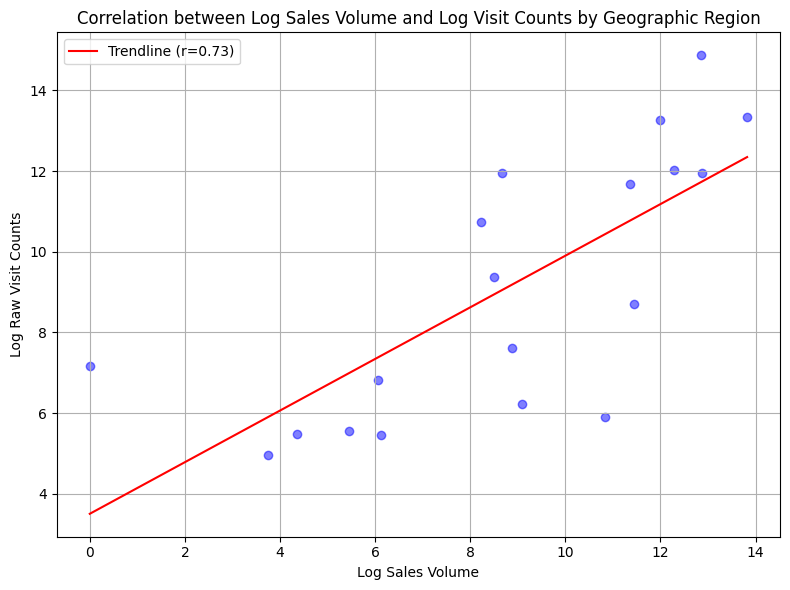

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Apply logarithmic transformation to the data
region_aggregate_df['log_raw_visit_counts'] = np.log1p(region_aggregate_df['raw_visit_counts'])
region_aggregate_df['log_sales_volume'] = np.log1p(region_aggregate_df['Sales Volume (9) - Location'])

# Calculate the linear regression line
slope, intercept, r_value, p_value, std_err = linregress(region_aggregate_df['log_sales_volume'], region_aggregate_df['log_raw_visit_counts'])
x_values = np.linspace(min(region_aggregate_df['log_sales_volume']), max(region_aggregate_df['log_sales_volume']), 100)
y_values = slope * x_values + intercept

# Create a scatter plot with logarithmic transformation
plt.figure(figsize=(8, 6))
plt.scatter(region_aggregate_df['log_sales_volume'], region_aggregate_df['log_raw_visit_counts'], color='blue', alpha=0.5)

# Add the trendline
plt.plot(x_values, y_values, color='red', label=f'Trendline (r={r_value:.2f})')

# Add labels and title
plt.title('Correlation between Log Sales Volume and Log Visit Counts by Geographic Region')
plt.xlabel('Log Sales Volume')
plt.ylabel('Log Raw Visit Counts')

# Show the plot
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
ann_arbor_bins = pd.read_csv('ann_arbor_bins.csv')

In [7]:
ann_arbor_bins

,Intersection,Trash,Recycle,Big Belly Trash,Big Belly Recycle,Area
0,5th & Catherine,2,0,0,0,1
1,5th & Kingsley,1,0,0,0,1
2,5th & Detroit,0,0,2,2,1
3,4th & Kingsley,0,0,0,0,1
4,Detroit & Kingsley,0,0,0,0,1
...,...,...,...,...,...,...
68,East U. & Willard,1,0,0,0,7
69,Church & Willard,1,0,0,0,7
70,South U. & Forest,1,1,1,0,8
71,South U. & Washtenaw,2,0,0,0,8


In [9]:
arbor_foot_traffic = pd.read_parquet('ann_arbor.parquet')

In [18]:
min_lat = min(list(arbor_foot_traffic['latitude']))
min_long = min(list(arbor_foot_traffic['longitude']))
max_lat = max(list(arbor_foot_traffic['latitude']))
max_long = max(list(arbor_foot_traffic['longitude']))

print(min_lat, min_long, max_lat, max_long)

42.161156 -83.954172 42.366596 -83.607212


In [10]:
arbor_foot_traffic.columns

Index(['placekey', 'safegraph_place_id', 'parent_placekey',
       'parent_safegraph_place_id', 'location_name', 'safegraph_brand_ids',
       'brands', 'top_category', 'sub_category', 'category_tags', 'naics_code',
       'latitude', 'longitude', 'street_address', 'city', 'region',
       'postal_code', 'iso_country_code', 'phone_number', 'open_hours',
       'opened_on', 'closed_on', 'tracking_opened_since',
       'tracking_closed_since', 'date_range_start', 'date_range_end',
       'raw_visit_counts', 'raw_visitor_counts', 'visits_by_day',
       'visitor_home_cbgs', 'visitor_country_of_origin', 'distance_from_home',
       'median_dwell', 'bucketed_dwell_times', 'related_same_day_brand',
       'related_same_month_brand', 'popularity_by_hour', 'popularity_by_day',
       'device_type', 'poi_cbg', 'visitor_daytime_cbgs'],
      dtype='object')

In [32]:
# Define a function to map latitude and longitude to area based on estimates
def get_area(row):
    latitude = row['latitude']
    longitude = row['longitude']
    if 42.2819 <= latitude <= 42.2846 and -83.7427 <= longitude <= -83.7411:
        return 1
    elif 42.2807 <= latitude <= 42.2837 and -83.7368 <= longitude <= -83.7362:
        return 2
    elif 42.2759 <= latitude <= 42.2806 and -83.7331 <= longitude <= -83.7319:
        return 3
    elif 42.2782 <= latitude <= 42.2797 and -83.7347 <= longitude <= -83.7334:
        return 4
    elif 42.2776 <= latitude <= 42.2788 and -83.7345 <= longitude <= -83.7333:
        return 5
    elif 42.2756 <= latitude <= 42.2772 and -83.7366 <= longitude <= -83.7357:
        return 6
    elif 42.2716 <= latitude <= 42.2737 and -83.7368 <= longitude <= -83.7332:
        return 7
    elif 42.2717 <= latitude <= 42.2737 and -83.7355 <= longitude <= -83.7329:
        return 8
    else:
        return None

# Apply the function to create the 'Area' column
arbor_foot_traffic['Area'] = arbor_foot_traffic.apply(get_area, axis=1)

In [33]:
arbor_foot_traffic['Area'].unique()

array([nan,  3.,  4.,  7.,  8.])

In [34]:
arbor_visit_areas = arbor_foot_traffic.dropna(subset=['Area'])[['raw_visit_counts', 'Area']].dropna().reset_index().drop(columns = ['index'])

In [35]:
arbor_visit_areas

,raw_visit_counts,Area
0,2594.0,3.0
1,2155.0,4.0
2,16.0,7.0
3,350.0,7.0
4,78.0,8.0
...,...,...
201,86.0,8.0
202,285.0,7.0
203,10.0,7.0
204,639.0,4.0


In [36]:
ann_arbor_bins.columns

Index(['Intersection', 'Trash', 'Recycle', 'Big Belly Trash',
       'Big Belly Recycle', 'Area', 'total_bins'],
      dtype='object')

In [37]:
ann_arbor_bins['total_bins'] = ann_arbor_bins['Trash'] + ann_arbor_bins['Recycle'] + ann_arbor_bins['Big Belly Trash'] + ann_arbor_bins['Big Belly Recycle']

In [38]:
ann_arbor_bins

,Intersection,Trash,Recycle,Big Belly Trash,Big Belly Recycle,Area,total_bins
0,5th & Catherine,2,0,0,0,1,2
1,5th & Kingsley,1,0,0,0,1,1
2,5th & Detroit,0,0,2,2,1,4
3,4th & Kingsley,0,0,0,0,1,0
4,Detroit & Kingsley,0,0,0,0,1,0
...,...,...,...,...,...,...,...
68,East U. & Willard,1,0,0,0,7,1
69,Church & Willard,1,0,0,0,7,1
70,South U. & Forest,1,1,1,0,8,3
71,South U. & Washtenaw,2,0,0,0,8,2


In [39]:
area_aggregate_df = ann_arbor_bins.groupby('Area').agg({
    'total_bins': 'sum'
}).reset_index()

In [40]:
area_aggregate_df

,Area,total_bins
0,1,15
1,2,8
2,3,19
3,4,14
4,5,16
5,6,22
6,7,9
7,8,6


In [41]:
visit_aggregate_df = arbor_visit_areas.groupby('Area').agg({
    'raw_visit_counts': 'sum'
}).reset_index()
visit_aggregate_df['Area'] = visit_aggregate_df['Area'].astype(int)

In [42]:
visit_aggregate_df

,Area,raw_visit_counts
0,3,62514.0
1,4,46487.0
2,7,103121.0
3,8,3256.0


In [43]:
bin_visit_areas = pd.merge(area_aggregate_df, visit_aggregate_df)
bin_visit_areas.columns

Index(['Area', 'total_bins', 'raw_visit_counts'], dtype='object')

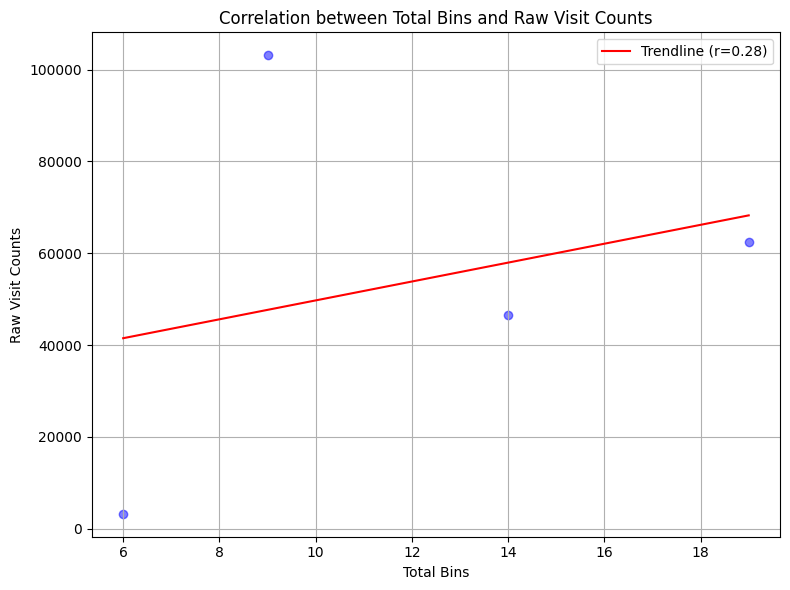

In [46]:
# Calculate the linear regression line
slope, intercept, r_value, p_value, std_err = linregress(bin_visit_areas['total_bins'], bin_visit_areas['raw_visit_counts'])
x_values = np.linspace(min(bin_visit_areas['total_bins']), max(bin_visit_areas['total_bins']), 100)
y_values = slope * x_values + intercept

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(bin_visit_areas['total_bins'], bin_visit_areas['raw_visit_counts'], color='blue', alpha=0.5)

# Add the trendline
plt.plot(x_values, y_values, color='red', label=f'Trendline (r={r_value:.2f})')

# Add labels and title
plt.title('Correlation between Total Bins and Raw Visit Counts')
plt.xlabel('Total Bins')
plt.ylabel('Raw Visit Counts')

# Show the plot
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
